In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
train_data_orig = pd.read_csv('train.csv')
test_data_orig = pd.read_csv('test.csv')
test_data_orig.loc[:, 'Survived'] = pd.np.nan
merged_data = pd.concat({'train': train_data_orig, 'test': test_data_orig}, axis=0, sort=False)

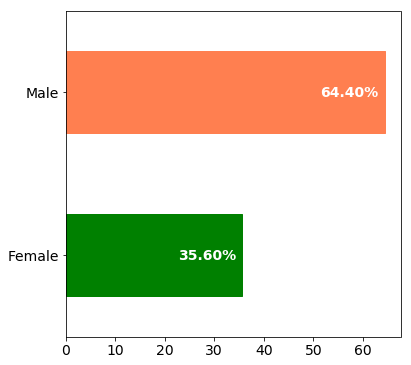

In [3]:
# Show gender distribution

output = merged_data[['PassengerId', 'Sex']].groupby('Sex').count() / len(merged_data['Sex']) * 100
output.columns = ['%']
output.reset_index(inplace=True)

ax = output.plot(kind='barh', figsize=(6, 6), fontsize=14)
ax.set_yticklabels(['Female', 'Male'])
ax.legend().remove()
ax.get_children()[0].set_color('green')
ax.get_children()[1].set_color('coral')

for idx in [0, 1]:
    ax.annotate(
        xy=(output.loc[idx, '%'] - 13, idx-0.03),
        s='{0:.2f}%'.format(output.loc[idx, '%']),
        color='white',
        weight='bold',
        fontsize=14)

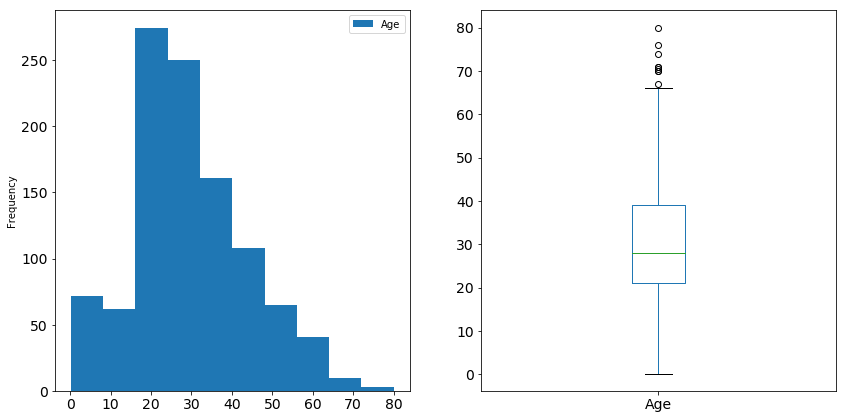

In [4]:
# Show age distribution
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False, figsize=(14, 7))
merged_data[['Age']].plot(kind='hist', ax=ax1, fontsize=14)
merged_data[['Age']].plot(kind='box', ax=ax2, fontsize=14)

Normal ticket survival %: 13.65% 67/491
Expensive ticket survival %: 33.62% 275/818
Ticket type survival rate: 2.46


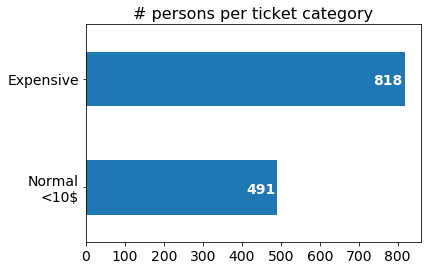

In [5]:
middle = 10

merged_data['Fare'].replace(pd.np.nan, merged_data['Fare'].mean(), inplace=True)
merged_data['Cabin'].replace(pd.np.nan, 'N/A', inplace=True)

count, bin_edges = np.histogram(merged_data['Fare'], [0, middle, 550])

categories = ['Normal', 'Expensive']

df_fare = pd.DataFrame({'count': count, 'category': categories})

df_fare.set_index('category', inplace=True)

ax = df_fare.plot(kind='barh', fontsize=14)

ax.set_ylabel('')
ax.legend().remove()

ax.set_title('# persons per ticket category', fontsize=16)

ax.set_yticklabels(['Normal\n<%s$' % middle, 'Expensive'])

for idx, cat in enumerate(categories):
    ax.annotate(
        xy=(df_fare.loc[cat, 'count'] - 80, idx - 0.05),
        s=df_fare.loc[cat, 'count'],
        color='white',
        weight='bold',
        fontsize=14)

    
def fare_survival(data, df_fare, middle):
    norm_cond = data['Fare'] < middle
    
    nt_survived = data.loc[norm_cond & (data['Survived'] == 1), ['Survived']].count()
    nt_total = data.loc[norm_cond, 'PassengerId'].count()
    nts = (nt_survived / nt_total).iloc[0] * 100
    print('Normal ticket survival %: {0:.2f}% {1}/{2}'.format(nts, nt_survived[0], nt_total))

    et_survived = data.loc[~norm_cond & (data['Survived'] == 1), ['Survived']].count()
    et_total = data.loc[~norm_cond, 'PassengerId'].count()
    ets = (et_survived / et_total).iloc[0] * 100
    print('Expensive ticket survival %: {0:.2f}% {1}/{2}'.format(ets, et_survived[0], et_total))

    print('Ticket type survival rate: {0:.2f}'.format(ets/nts))


fare_survival(merged_data, df_fare, middle)

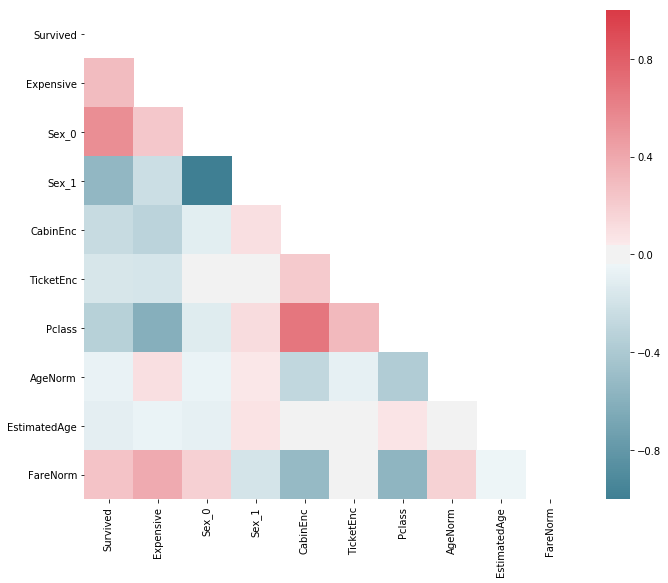

In [7]:
def encode_label(data, label, encoder):
    data[label].replace(pd.np.nan, 'N/A', inplace=True)
    encoding = pd.Series(encoder.transform(data[label]))
    data = pd.concat([data, encoding], axis=1)
    data.rename(columns={0: '{}Enc'.format(label)}, inplace=True)
    return data


def one_hot_encodings(data, field):
    data[field].replace(pd.np.nan, 'N/A', inplace=True)
    
    label_encoder = preprocessing.LabelEncoder()
    label_encodings = label_encoder.fit_transform(data[field])
        
    oh_encoder = preprocessing.OneHotEncoder(sparse=False)
    oh_encodings = oh_encoder.fit_transform(label_encodings.reshape(-1, 1))
    oh_encodings_df = pd.DataFrame(
        oh_encodings,
        columns=['{}_{}'.format(field, it) for it in range(0, oh_encodings.shape[1])],
        index=data.index
    )
    
    return pd.DataFrame({'{}Enc'.format(field): label_encodings}, index=data.index), oh_encodings_df


class Norm():
    
    def __init__(self, data, field):
        self.mean = data[field].mean()
        self.std = data[field].std()
        
    def normalize(self, data, field):
        return data[field] - self.mean / self.std


age_norm = Norm(merged_data, 'Age')
fare_norm = Norm(merged_data, 'Fare')

encoders = dict(
    cabin_encoder=preprocessing.LabelEncoder(),
    embarked_encoder=preprocessing.LabelEncoder(),
    ticket_encoder=preprocessing.LabelEncoder()
)

# encoders['cabin_encoder'].fit(merged_data['Cabin'])
# encoders['embarked_encoder'].fit(merged_data['Embarked'])
# encoders['ticket_encoder'].fit(merged_data['Ticket'])


def preprocess(data_orig):
    # Encode gender
    # male=-1, female=1
    data = data_orig.copy(deep=True)
    
    data['Sex'].replace(pd.np.nan, 'N/A', inplace=True)
    data['Cabin'].replace(pd.np.nan, 'N/A', inplace=True)
    data['Embarked'].replace(pd.np.nan, 'N/A', inplace=True)
    data['Ticket'].replace(pd.np.nan, 'N/A', inplace=True)
    
    # Encode Cabin
    cabin_label_encodings, cabin_oh_encodings = one_hot_encodings(data, 'Cabin')
    data = pd.concat([data, cabin_label_encodings], axis=1)
    data = pd.concat([data, cabin_oh_encodings], axis=1)
        
    # Encode Embarked
    embarked_label_encodings, embarked_oh_encodings = one_hot_encodings(data, 'Embarked')
    data = pd.concat([data, embarked_label_encodings], axis=1)
    data = pd.concat([data, embarked_oh_encodings], axis=1)

    
    # Encode Sex
    sex_label_encodings, sex_oh_encodings = one_hot_encodings(data, 'Sex')
    data = pd.concat([data, sex_label_encodings], axis=1)
    data = pd.concat([data, sex_oh_encodings], axis=1)


    # Encode Ticket
    ticket_label_encodings, ticket_oh_encodings = one_hot_encodings(data, 'Ticket')
    data = pd.concat([data, ticket_label_encodings], axis=1)
    data = pd.concat([data, ticket_oh_encodings], axis=1)
    
    # Replace missing age
    age_mean = np.floor(data[['Age']].mean()) + 0.5
    data['Age'] = data.Age.apply(lambda x: x if not pd.isnull(x) else age_mean.iloc[0])
    
    # Replace missing fare
    fare_mean = (data[['Fare']].mean())
    data['Fare'] = data.Fare.apply(lambda x: x if not pd.isnull(x) else fare_mean.iloc[0])

    
    # Estimated Age
    data.loc[:, 'EstimatedAge'] = 0
    data.loc[(data_orig['Age'] > 1) & ((data_orig['Age'] / 0.5) % 2 > 0), 'EstimatedAge'] = 1
    
    # # Encode Cabin
    # data = encode_label(data, 'Cabin', encoders['cabin_encoder'])
    
    # Add expensive indicator
    data.loc[:, 'Expensive'] = 0
    data.loc[(data['Fare'] >= middle), 'Expensive'] = 1
    
    data['AgeNorm'] = age_norm.normalize(data, 'Age')
    data['FareNorm'] = fare_norm.normalize(data, 'Fare')

    data = pd.concat([data, pd.get_dummies(data['Pclass'])], axis=1)
    data.rename(columns={1: "Pclass1", 2: "Pclass2", 3: "Pclass3"}, inplace=True)
    return data

improved_merged_data = preprocess(merged_data)

train_data = improved_merged_data.loc['train', :]
test_data = improved_merged_data.loc['test', :]

X, y = train_data.drop(columns=['Survived']), train_data[['Survived']]

x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=13)

corr = improved_merged_data[
    ['Survived', 'Expensive', 'Sex_0', 'Sex_1', 'CabinEnc', 'TicketEnc', 'Pclass', 'AgeNorm', 'EstimatedAge', 'FareNorm']
].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.diverging_palette(220, 10, as_cmap=True)

f, ax = plt.subplots(figsize=(11, 9))

sns.heatmap(corr, cmap=cmap, mask=mask, ax=ax);

# gender_survival = train_data_orig[['Sex', 'Survived']].groupby('Sex').count()
# (gender_survival / train_data_orig[['Sex']].shape[0]).plot(kind='bar')

In [8]:
print(merged_data.describe())

       PassengerId       Pclass          Age        SibSp        Parch  \
count  1309.000000  1309.000000  1046.000000  1309.000000  1309.000000   
mean    655.000000     2.294882    29.881138     0.498854     0.385027   
std     378.020061     0.837836    14.413493     1.041658     0.865560   
min       1.000000     1.000000     0.170000     0.000000     0.000000   
25%     328.000000     2.000000    21.000000     0.000000     0.000000   
50%     655.000000     3.000000    28.000000     0.000000     0.000000   
75%     982.000000     3.000000    39.000000     1.000000     0.000000   
max    1309.000000     3.000000    80.000000     8.000000     9.000000   

              Fare    Survived  
count  1309.000000  891.000000  
mean     33.295479    0.383838  
std      51.738879    0.486592  
min       0.000000    0.000000  
25%       7.895800    0.000000  
50%      14.454200    0.000000  
75%      31.275000    1.000000  
max     512.329200    1.000000  


In [9]:
merged_data.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
Survived       float64
dtype: object

In [10]:
print(merged_data.head())

        PassengerId  Pclass                                          Name  \
test 0          892       3                              Kelly, Mr. James   
     1          893       3              Wilkes, Mrs. James (Ellen Needs)   
     2          894       2                     Myles, Mr. Thomas Francis   
     3          895       3                              Wirz, Mr. Albert   
     4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)   

           Sex   Age  SibSp  Parch   Ticket     Fare Cabin Embarked  Survived  
test 0    male  34.5      0      0   330911   7.8292   N/A        Q       NaN  
     1  female  47.0      1      0   363272   7.0000   N/A        S       NaN  
     2    male  62.0      0      0   240276   9.6875   N/A        Q       NaN  
     3    male  27.0      0      0   315154   8.6625   N/A        S       NaN  
     4  female  22.0      1      1  3101298  12.2875   N/A        S       NaN  


In [11]:
import numpy as np
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

columns = [
    # 'TicketEnc',
    # 'EmbarkedEnc',
    # 'Parch',
    'Pclass',
    # 'SibSp',
    'AgeNorm',
    # 'EstimatedAge',
    # 'CabinEnc',
    # 'Fare',
    'FareNorm',
    'SexEnc',
    'Expensive'
]

Input=[
    ('scale', StandardScaler()),
    ('polynomial', PolynomialFeatures(degree=8, include_bias=False)),
    # ('model', svm.SVC(kernel='linear', C=1, class_weight={0: 0.4, 1: 0.6}, random_state=13))
    ('model', svm.SVC(kernel='linear', degree=8, C=1, random_state=13))
]

pipe=Pipeline(Input)

# condition = (x_train['Sex'] == 'female')
# pipe.fit(x_train.loc[condition, columns], y_train.loc[condition, 'Survived'])
pipe.fit(x_train.loc[:, columns], y_train.loc[:, 'Survived'])

Pipeline(memory=None,
     steps=[('scale', StandardScaler(copy=True, with_mean=True, with_std=True)), ('polynomial', PolynomialFeatures(degree=8, include_bias=False, interaction_only=False)), ('model', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=8, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=13, shrinking=True,
  tol=0.001, verbose=False))])

In [12]:
from sklearn.model_selection import cross_val_score

predicted = pipe.predict(x_val[columns])
print('Validation accuracy:')
print(pipe.score(x_val[columns], y_val['Survived']))

condition = (x_val['Sex'] == 'male')
print('Validation Male accuracy:')
print(pipe.score(x_val.loc[condition, columns], y_val.loc[condition, 'Survived']))

condition = (x_val['Sex'] == 'female')
print('Validation Female accuracy:')
print(pipe.score(x_val.loc[condition, columns], y_val.loc[condition, 'Survived']))

Validation accuracy:
0.8134328358208955
Validation Male accuracy:
0.8433734939759037
Validation Female accuracy:
0.7647058823529411


In [13]:
# Cross validation

scores = cross_val_score(pipe, train_data[columns], train_data['Survived'], cv=4)
print(scores.min())

0.7276785714285714


In [14]:
predicted = pipe.predict(test_data[columns])
to_save = pd.concat([test_data.drop(columns=['Survived']), pd.Series(predicted)], axis=1).rename(columns={0: 'Survived'})
print(to_save[['PassengerId', 'Survived']])
to_save[['PassengerId', 'Survived']].to_csv('svc-submission.csv', header=True, index=False)

     PassengerId  Survived
0            892       0.0
1            893       0.0
2            894       0.0
3            895       0.0
4            896       1.0
5            897       0.0
6            898       1.0
7            899       0.0
8            900       1.0
9            901       0.0
10           902       0.0
11           903       1.0
12           904       1.0
13           905       0.0
14           906       1.0
15           907       1.0
16           908       0.0
17           909       0.0
18           910       1.0
19           911       0.0
20           912       0.0
21           913       0.0
22           914       1.0
23           915       0.0
24           916       1.0
25           917       0.0
26           918       1.0
27           919       0.0
28           920       0.0
29           921       0.0
..           ...       ...
388         1280       0.0
389         1281       1.0
390         1282       0.0
391         1283       0.0
392         1284       0.0
3

/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/opt/conda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


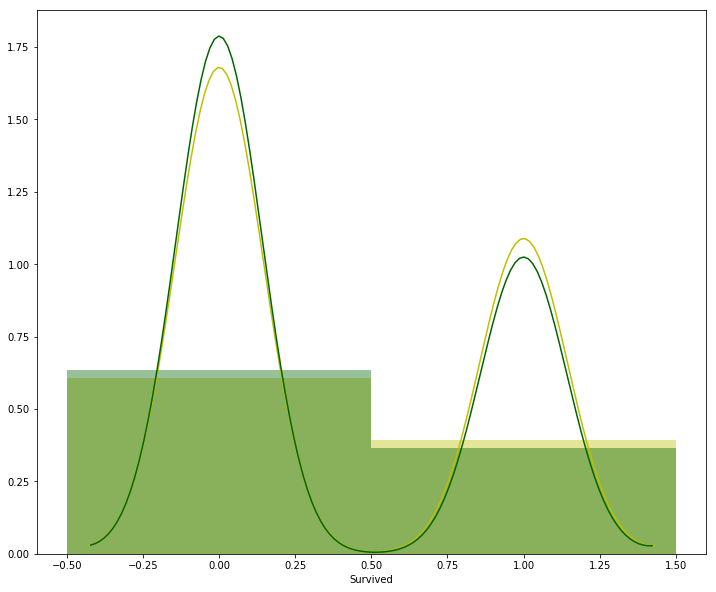

In [15]:
width = 12
height = 10
plt.figure(figsize=(width, height))

Yhat = pipe.predict(x_train[columns])

bins = [-.5, .5, 1.5]
ax1 = sns.distplot(y_train['Survived'], bins=bins, kde=True, hist=True, color="y", label="Actual Value")
sns.distplot(Yhat, bins=bins, kde=True, hist=True, color="darkgreen", label="Fitted Values", ax=ax1)

In [16]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.utils import to_categorical
from keras import regularizers

columns = [
    'SibSp',
    'Parch',
    # 'EmbarkedEnc',
    # 'Fare',
    # 'CabinEnc',
    'AgeNorm',
    'FareNorm',
    'EstimatedAge',
    'Pclass',
    'Sex_0',
    'Sex_1',
    # 'TicketEnc',
    'Expensive',
] + [
    it for it in improved_merged_data.columns if 'Cabin_' in it
] + [
    it for it in improved_merged_data.columns if 'Ticket_' in it
]

/opt/conda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [17]:
to_train = x_train[columns]
to_validate = x_val[columns]

lin = Input(shape=(len(columns),))
l1 = Dense(32, activation='relu', kernel_initializer='he_normal')(lin)
l1_drop = Dropout(0.5)(l1)
# l2 = Dense(16, activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(0.03))(l1)
lout = Dense(2, activation='softmax')(l1)

model = Model(inputs=lin, outputs=lout)

model.compile(
    optimizer='adagrad',
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy'])

model.fit(
    to_train, to_categorical(y_train['Survived'], 2),
    validation_data=(to_validate, to_categorical(y_val['Survived'], 2)),
    epochs=100,
    steps_per_epoch=10, validation_steps=1,
    verbose=1,
    shuffle=True)

print(model.evaluate(to_validate, to_categorical(y_val['Survived'], 2)))

Train on 623 samples, validate on 268 samples
Epoch 1/100
10/10 [==============================] - 0s 13ms/step - loss: 0.7910 - categorical_accuracy: 0.6822 - val_loss: 0.5507 - val_categorical_accuracy: 0.7537
Epoch 2/100
10/10 [==============================] - 0s 5ms/step - loss: 0.4478 - categorical_accuracy: 0.8258 - val_loss: 0.4810 - val_categorical_accuracy: 0.8060
Epoch 3/100
10/10 [==============================] - 0s 5ms/step - loss: 0.3881 - categorical_accuracy: 0.8695 - val_loss: 0.4632 - val_categorical_accuracy: 0.8284
Epoch 4/100
10/10 [==============================] - 0s 5ms/step - loss: 0.3320 - categorical_accuracy: 0.9154 - val_loss: 0.4491 - val_categorical_accuracy: 0.8396
Epoch 5/100
10/10 [==============================] - 0s 5ms/step - loss: 0.2956 - categorical_accuracy: 0.9274 - val_loss: 0.4385 - val_categorical_accuracy: 0.8358
Epoch 6/100
10/10 [==============================] - 0s 5ms/step - loss: 0.2659 - categorical_accuracy: 0.9372 - val_loss: 0.431

10/10 [==============================] - 0s 5ms/step - loss: 0.0415 - categorical_accuracy: 0.9952 - val_loss: 0.4326 - val_categorical_accuracy: 0.8284
Epoch 51/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0408 - categorical_accuracy: 0.9952 - val_loss: 0.4335 - val_categorical_accuracy: 0.8284
Epoch 52/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0401 - categorical_accuracy: 0.9952 - val_loss: 0.4344 - val_categorical_accuracy: 0.8284
Epoch 53/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0394 - categorical_accuracy: 0.9952 - val_loss: 0.4352 - val_categorical_accuracy: 0.8284
Epoch 54/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0388 - categorical_accuracy: 0.9952 - val_loss: 0.4361 - val_categorical_accuracy: 0.8284
Epoch 55/100
10/10 [==============================] - 0s 5ms/step - loss: 0.0382 - categorical_accuracy: 0.9952 - val_loss: 0.4371 - val_categorical_accuracy: 0.8284
Epoch 56/100
10/1

10/10 [==============================] - 0s 4ms/step - loss: 0.0240 - categorical_accuracy: 0.9952 - val_loss: 0.4741 - val_categorical_accuracy: 0.8321
Epoch 100/100
268/268 [==============================] - 0s 19us/step
[0.47499272360730527, 0.8320895531284276]


In [18]:
predicted = model.predict(test_data[columns])
output = []

# [0. 1.] means Survived
for idx, item in enumerate(predicted):
    output.append(int(item[0] < item[1]))

output = pd.Series(output, index=test_data['PassengerId'])
to_save = output.reset_index()
to_save.columns = ['PassengerId', 'Survived']
print(to_save[['PassengerId', 'Survived']])
to_save[['PassengerId', 'Survived']].to_csv('submission.csv', header=True, index=False)

     PassengerId  Survived
0            892         0
1            893         1
2            894         0
3            895         0
4            896         1
5            897         0
6            898         1
7            899         1
8            900         1
9            901         0
10           902         0
11           903         0
12           904         1
13           905         0
14           906         1
15           907         0
16           908         0
17           909         0
18           910         1
19           911         1
20           912         0
21           913         0
22           914         1
23           915         0
24           916         1
25           917         0
26           918         1
27           919         0
28           920         0
29           921         0
..           ...       ...
388         1280         0
389         1281         0
390         1282         1
391         1283         1
392         1284         0
3

In [19]:
!kaggle competitions submit -c titanic -f submission.csv -m ""

Successfully submitted to Titanic: Machine Learning from Disaster